# Using Ragas to Evaluate a RAG Application built with LangChain and LangGraph

In the following notebook, we'll be looking at how [Ragas](https://github.com/explodinggradients/ragas) can be helpful in a number of ways when looking to evaluate your RAG applications!

While this example is rooted in LangChain/LangGraph - Ragas is framework agnostic (you don't even need to be using a framework!).

- 🤝 Breakout Room #1
  1. Task 1: Installing Required Libraries
  2. Task 2: Set Environment Variables
  3. Task 3: Synthetic Dataset Generation for Evaluation using Ragas
  4. Task 4: Evaluating our Pipeline with Ragas
  5. Task 6: Making Adjustments and Re-Evaluating

But first! Let's set some dependencies!

## Dependencies and API Keys:

> NOTE: Please skip the pip install commands if you are running the notebook locally.

In [1]:
#!pip install -qU ragas==0.2.10

In [3]:
#!pip install -qU langchain-community==0.3.14 langchain-openai==0.2.14 unstructured==0.16.12 langgraph==0.2.61 langchain-qdrant==0.2.0

We'll also need to provide our API keys.

First, OpenAI's for our LLM/embedding model combination!

In [1]:
import os
from getpass import getpass
os.environ["OPENAI_API_KEY"] = getpass("Please enter your OpenAI API key!")

## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data - and download our webpages which we'll be using for our data today.

These webpages are from [Simon Willison's](https://simonwillison.net/) yearly "AI learnings".

- [2023 Blog](https://simonwillison.net/2023/Dec/31/ai-in-2023/)
- [2024 Blog](https://simonwillison.net/2024/Dec/31/llms-in-2024/)

Let's start by collecting our data into a useful pile!

In [2]:
!mkdir data

In [3]:
!curl https://simonwillison.net/2023/Dec/31/ai-in-2023/ -o data/2023_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31524    0 31524    0     0   188k      0 --:--:-- --:--:-- --:--:--  188k


In [4]:
!curl https://simonwillison.net/2024/Dec/31/llms-in-2024/ -o data/2024_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 70549    0 70549    0     0   114k      0 --:--:-- --:--:-- --:--:--  114k


Next, let's load our data into a familiar LangChain format using the `DirectoryLoader`.

In [2]:
from langchain_community.document_loaders import DirectoryLoader

path = "data/"
loader = DirectoryLoader(path, glob="*.html")
docs = loader.load()

### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [3]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

In [4]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/26 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [5]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,Wut role does Gooogle play in the LLM space ac...,[We don’t yet know how to build GPT-4 Vibes Ba...,"According to the context, Google is one of the...",single_hop_specifc_query_synthesizer
1,wHy is gpt-4 stil not beetin by other lLMs?,[I’m surprised that no-one has beaten the now ...,No-one has beaten the now almost year old GPT-...,single_hop_specifc_query_synthesizer
2,what is AI mean now,[Simon Willison’s Weblog Subscribe Stuff we fi...,"AI now can refer to Large Language Models, whi...",single_hop_specifc_query_synthesizer
3,What is the significance of the leaked Google ...,[Microsoft over this issue. The 69 page PDF is...,"According to the provided context, the leaked ...",single_hop_specifc_query_synthesizer
4,How has the use of synthetic data in language ...,[<1-hop>\n\nmodel available to try out through...,The concern about model collapse from recursiv...,multi_hop_abstract_query_synthesizer
5,"what models do multi-modal ai now, like vision...",[<1-hop>\n\nyou talk to me exclusively in Span...,openai and google gemini both have multi-modal...,multi_hop_abstract_query_synthesizer
6,How has the rise of fine-tuning and customizat...,[<1-hop>\n\nWe don’t yet know how to build GPT...,The current landscape of LLM-powered applicati...,multi_hop_abstract_query_synthesizer
7,How has the increasing use of synthetic data i...,[<1-hop>\n\nmodel available to try out through...,The increasing use of synthetic data in langua...,multi_hop_abstract_query_synthesizer
8,What are the notable contributions of Google t...,[<1-hop>\n\nThe rise of inference-scaling “rea...,"In 2024, Google made significant contributions...",multi_hop_specific_query_synthesizer
9,How has Anthropic contributed to the recent tr...,[<1-hop>\n\nskeptical as to their utility base...,Anthropic has played a significant role in the...,multi_hop_specific_query_synthesizer


In [6]:
dataset

Testset(samples=[TestsetSample(eval_sample=SingleTurnSample(user_input='Wut role does Gooogle play in the LLM space acccording to the context?', retrieved_contexts=None, reference_contexts=['We don’t yet know how to build GPT-4 Vibes Based Development LLMs are really smart, and also really, really dumb Gullibility is the biggest unsolved problem Code may be the best application The ethics of this space remain diabolically complex My blog in 2023 Here’s the sequel to this post: Things we learned about LLMs in 2024. Large Language Models In the past 24-36 months, our species has discovered that you can take a GIANT corpus of text, run it through a pile of GPUs, and use it to create a fascinating new kind of software. LLMs can do a lot of things. They can answer questions, summarize documents, translate from one language to another, extract information and even write surprisingly competent code. They can also help you cheat at your homework, generate unlimited streams of fake content and 

In [7]:
dataset.to_pandas().iloc[11]['reference_contexts']


['<1-hop>\n\nThe rise of inference-scaling “reasoning” models Was the best currently available LLM trained in China for less than $6m? The environmental impact got better The environmental impact got much, much worse The year of slop Synthetic training data works great LLMs somehow got even harder to use Knowledge is incredibly unevenly distributed LLMs need better criticism Everything tagged “llms” on my blog in 2024 The GPT-4 barrier was comprehensively broken In my December 2023 review I wrote about how We don’t yet know how to build GPT-4—OpenAI’s best model was almost a year old at that point, yet no other AI lab had produced anything better. What did OpenAI know that the rest of us didn’t? I’m relieved that this has changed completely in the past twelve months. 18 organizations now have models on the Chatbot Arena Leaderboard that rank higher than the original GPT-4 from March 2023 (GPT-4-0314 on the board)—70 models in total. Screenshot of a comparison table showing AI model ran

In [8]:
dataset.to_pandas().iloc[11]['reference']


'The launch of Claude 3.5 Sonnet in June marked a significant advancement in the trend of increased context lengths among LLMs, as highlighted in the context. While models like Claude 2.1 had already pushed context windows to 200,000 tokens, the broader industry shift saw every major provider offering models with 100,000+ token capacities, enabling users to input entire books or large codebases for more complex problem-solving. Claude 3.5 Sonnet also introduced Claude Artifacts, a feature that allowed users to generate and interact with on-demand applications directly within the Claude interface, exemplifying the rise of prompt-driven app generation. This capability made it easier for users to build and iterate on custom tools and visualizations, further democratizing advanced AI-powered workflows. Additionally, for a brief period in 2024, Claude 3.5 Sonnet was freely available to most users, alongside other top models like GPT-4o and Gemini 1.5 Pro. This unprecedented free access allo

## LangChain RAG

Now we'll construct our LangChain RAG, which we will be evaluating using the above created test data!

### R - Retrieval

Let's start with building our retrieval pipeline, which will involve loading the same data we used to create our synthetic test set above.

> NOTE: We need to use the same data - as our test set is specifically designed for this data.

In [9]:
path = "data/"
loader = DirectoryLoader(path, glob="*.html")
docs = loader.load()

Now that we have our data loaded, let's split it into chunks!

In [11]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
split_documents = text_splitter.split_documents(docs)
len(split_documents)


75

Now, nodes is a list of semantically split + embedded chunks (ready to be inserted into any vector store).



Next up, we'll need to provide an embedding model that we can use to construct our vector store.

In [12]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

Now we can build our in memory QDrant vector store.

In [13]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(":memory:")

client.create_collection(
    collection_name="ai_across_years",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

vector_store = QdrantVectorStore(
    client=client,
    collection_name="ai_across_years",
    embedding=embeddings,
)

We can now add our documents to our vector store.

In [14]:
_ = vector_store.add_documents(documents=split_documents)

Let's define our retriever.

In [15]:
retriever = vector_store.as_retriever(search_kwargs={"k": 5})

Now we can produce a node for retrieval!

In [28]:
# def retrieve(state):
#   retrieved_docs = retriever.invoke(state["question"])
#   return {"context" : retrieved_docs}

### Augmented

Let's create a simple RAG prompt!

In [16]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
You are a helpful assistant who answers questions based on provided context. You must only use the provided context, and cannot use your own knowledge.

### Question
{question}

### Context
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

### Generation

We'll also need an LLM to generate responses - we'll use `gpt-4o-mini` to avoid using the same model as our judge model.

In [17]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

Then we can create a `generate` node!

In [27]:
# def generate(state):
#   docs_content = "\n\n".join(doc.page_content for doc in state["context"])
#   messages = rag_prompt.format_messages(question=state["question"], context=docs_content)
#   response = llm.invoke(messages)
#   return {"response" : response.content}

### Building RAG Graph with LangGraph

Let's create some state for our LangGraph RAG graph!

In [18]:
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class State(TypedDict):
  question: str
  context: List[Document]
  response: str

In [19]:
def retrieve(state):
  retrieved_docs = retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

In [20]:
def generate(state):
  docs_content = "\n\n".join(doc.page_content for doc in state["context"])
  RA_in_propmt = rag_prompt.format_messages(question=state["question"], context=docs_content)
  G_in_rag = llm.invoke(RA_in_propmt)
  return {"response" : G_in_rag.content}

Now we can build our simple graph!

> NOTE: We're using `add_sequence` since we will always move from retrieval to generation. This is essentially building a chain in LangGraph.

In [21]:
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

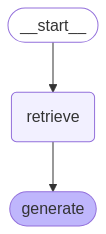

In [22]:
graph

Let's do a test to make sure it's doing what we'd expect.

In [23]:
response = graph.invoke({"question" : "How are LLM agents useful?"})

In [24]:
response

{'question': 'How are LLM agents useful?',
 'context': [Document(metadata={'source': 'data/2024_llms.html', '_id': 'e868b359a91d4b548a237499d4727b23', '_collection_name': 'ai_across_years'}, page_content='The two main categories I see are people who think AI agents are obviously things that go and act on your behalf—the travel agent model—and people who think in terms of LLMs that have been given access to tools which they can run in a loop as part of solving a problem. The term “autonomy” is often thrown into the mix too, again without including a clear definition.\n\n(I also collected 211 definitions on Twitter a few months ago—here they are in Datasette Lite—and had gemini-exp-1206 attempt to summarize them.)\n\nWhatever the term may mean, agents still have that feeling of perpetually “coming soon”.\n\nTerminology aside, I remain skeptical as to their utility based, once again, on the challenge of gullibility. LLMs believe anything you tell them. Any systems that attempts to make me

In [25]:
response["response"]

'LLM agents are useful in various ways, primarily functioning as tools that can act on behalf of users, akin to how a travel agent operates. They can assist in problem-solving by running loops with access to different tools, which allows for a more dynamic interaction in achieving tasks.\n\nOne significant aspect of LLMs is their accessibility; they can be built relatively easily with just a few hundred lines of code, provided sufficient quality and quantity of training data is available. This means that while training an LLM still requires substantial resources, it is no longer restricted to only the wealthiest entities.\n\nMoreover, LLMs can now be run on personal devices, making them more widely available for individual use. This democratization of technology enhances their utility in various contexts.\n\nDespite their potential, LLMs also face challenges such as the tendency to generate false information (hallucinations), which raises concerns about their reliability. However, in s

## Evaluating the App with Ragas

Now we can finally do our evaluation!

We'll start by running the queries we generated usign SDG above through our application to get context and responses.

In [26]:
for test_row in dataset:
  response = graph.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"]
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [27]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,Wut role does Gooogle play in the LLM space ac...,"[Since then, almost every major LLM (and most ...",[We don’t yet know how to build GPT-4 Vibes Ba...,"According to the context, Google plays a signi...","According to the context, Google is one of the...",single_hop_specifc_query_synthesizer
1,wHy is gpt-4 stil not beetin by other lLMs?,[So training an LLM still isn’t something a ho...,[I’m surprised that no-one has beaten the now ...,GPT-4 has not yet been beaten by other large l...,No-one has beaten the now almost year old GPT-...,single_hop_specifc_query_synthesizer
2,what is AI mean now,[A lot of people are excited about AI agents—a...,[Simon Willison’s Weblog Subscribe Stuff we fi...,"In the provided context, ""AI"" refers to artifi...","AI now can refer to Large Language Models, whi...",single_hop_specifc_query_synthesizer
3,What is the significance of the leaked Google ...,"[Since then, almost every major LLM (and most ...",[Microsoft over this issue. The 69 page PDF is...,The leaked Google document titled 'We Have No ...,"According to the provided context, the leaked ...",single_hop_specifc_query_synthesizer
4,How has the use of synthetic data in language ...,[Slop was even in the running for Oxford Word ...,[<1-hop>\n\nmodel available to try out through...,The use of synthetic data in language model tr...,The concern about model collapse from recursiv...,multi_hop_abstract_query_synthesizer
5,"what models do multi-modal ai now, like vision...","[Multimodal vision is common, audio and video ...",[<1-hop>\n\nyou talk to me exclusively in Span...,"In 2024, the landscape of multi-modal AI has s...",openai and google gemini both have multi-modal...,multi_hop_abstract_query_synthesizer
6,How has the rise of fine-tuning and customizat...,[You can even run them entirely in your browse...,[<1-hop>\n\nWe don’t yet know how to build GPT...,The rise of fine-tuning and customization by h...,The current landscape of LLM-powered applicati...,multi_hop_abstract_query_synthesizer
7,How has the increasing use of synthetic data i...,[One of the best descriptions I’ve seen of thi...,[<1-hop>\n\nmodel available to try out through...,The increasing use of synthetic data in langua...,The increasing use of synthetic data in langua...,multi_hop_abstract_query_synthesizer
8,What are the notable contributions of Google t...,[I’m relieved that this has changed completely...,[<1-hop>\n\nThe rise of inference-scaling “rea...,"In 2024, Google made notable contributions to ...","In 2024, Google made significant contributions...",multi_hop_specific_query_synthesizer
9,How has Anthropic contributed to the recent tr...,"[LLM prices crashed, thanks to competition and...",[<1-hop>\n\nskeptical as to their utility base...,Anthropic has made a significant impact on the...,Anthropic has played a significant role in the...,multi_hop_specific_query_synthesizer


Then we can convert that table into a `EvaluationDataset` which will make the process of evaluation smoother.

In [28]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

We'll need to select a judge model - in this case we're using the same model that was used to generate our Synthetic Data.

In [29]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-mini"))

Next up - we simply evaluate on our desired metrics!

In [30]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Exception raised in Job[2]: AttributeError('StringIO' object has no attribute 'statements')
Exception raised in Job[32]: AttributeError('StringIO' object has no attribute 'statements')
Exception raised in Job[65]: AttributeError('StringIO' object has no attribute 'statements')
Exception raised in Job[59]: AttributeError('StringIO' object has no attribute 'statements')
Exception raised in Job[53]: AttributeError('StringIO' object has no attribute 'statements')
Exception raised in Job[62]: AttributeError('StringIO' object has no attribute 'statements')


{'context_recall': 0.7250, 'faithfulness': 0.9132, 'factual_correctness': 0.5789, 'answer_relevancy': 0.8649, 'context_entity_recall': 0.5060, 'noise_sensitivity_relevant': 0.4432}

## Making Adjustments and Re-Evaluating

Now that we've got our baseline - let's make a change and see how the model improves or doesn't improve!

> NOTE: This will be using Cohere's Rerank model (which was updated fairly [recently](https://docs.cohere.com/v2/changelog/rerank-v3.5)) - please be sure to [sign-up for an API key!](https://docs.cohere.com/reference/about)

# Semantic Chunking

I used LlamaIndex's SemanticSplitterNodeParser:

In [35]:
from llama_index.core import SimpleDirectoryReader
path = "data/"
reader = SimpleDirectoryReader(path)
documents = reader.load_data()


In [37]:
from llama_index.core.node_parser import SemanticSplitterNodeParser
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core import SimpleDirectoryReader
from llama_index.core.settings import Settings

node_parser = SemanticSplitterNodeParser(
    embed_model=Settings.embed_model,
    chunk_size=1024,  # token size
    chunk_overlap=128
)

nodes = node_parser.get_nodes_from_documents(documents)

## Store in LangChain Vector Store
## Convert nodes to LangChain documents and insert

In [38]:
from langchain.docstore.document import Document

# Convert to LangChain-compatible documents
lc_docs = [Document(page_content=node.text, metadata=node.metadata) for node in nodes]


In [48]:
len(lc_docs)

14

In [39]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(":memory:")

client.create_collection(
    collection_name="ai_across_years_semantic",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

vector_store = QdrantVectorStore(
    client=client,
    collection_name="ai_across_years_semantic",
    embedding=embeddings,
)

In [40]:
_=vector_store.add_documents(documents=lc_docs)

In [54]:
retrieve_with_semantic_chunking_retriever=vector_store.as_retriever(search_kwargs={'k':5})

In [55]:
def retrieve_with_semantic_chunking(state):
    # Use the vector_store retriever that you created earlier
    retrieved_docs = retrieve_with_semantic_chunking_retriever.invoke(state["question"])
    # Or simply:
    # retrieved_docs = vector_store.as_retriever(search_kwargs={"k": 5}).invoke(state["question"])
    return {"context": retrieved_docs}

In [56]:
graph_builder = StateGraph(State).add_sequence([retrieve_with_semantic_chunking, generate])
graph_builder.add_edge(START, "retrieve_with_semantic_chunking")
graph_with_semantic_chunking = graph_builder.compile()

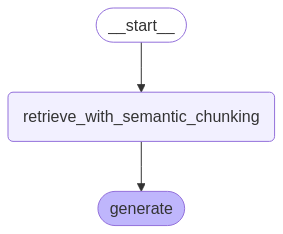

In [57]:
graph_with_semantic_chunking

In [58]:
response = graph_with_semantic_chunking.invoke({"question" : "How are LLM agents useful?"})

Evaluation

In [59]:
for test_row in dataset:
  response = graph_with_semantic_chunking.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"]
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [60]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

In [61]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Exception raised in Job[1]: AttributeError('StringIO' object has no attribute 'statements')
Exception raised in Job[5]: AttributeError('StringIO' object has no attribute 'statements')
Exception raised in Job[28]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4.1-mini in organization org-yoeqMMRSPsqCueoK3654BtHz on tokens per min (TPM): Limit 200000, Used 198386, Requested 15136. Please try again in 4.056s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
Exception raised in Job[36]: RateLimitError(Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4.1-mini in organization org-yoeqMMRSPsqCueoK3654BtHz on tokens per min (TPM): Limit 200000, Used 196172, Requested 15775. Please try again in 3.584s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
Exception raised

{'context_recall': 0.7273, 'faithfulness': 0.8896, 'factual_correctness': 0.5555, 'answer_relevancy': 0.9318, 'context_entity_recall': 0.4447, 'noise_sensitivity_relevant': 0.4555}

In [ ]:

# Naive RAG
{'context_recall': 0.7250, 'faithfulness': 0.9132, 'factual_correctness': 0.5789, 'answer_relevancy': 0.8649, 'context_entity_recall': 0.5060, 'noise_sensitivity_relevant': 0.4432}

#Semantic Chunking USIN LlamIndxe
{'context_recall': 0.7273, 'faithfulness': 0.8896, 'factual_correctness': 0.5555, 'answer_relevancy': 0.9318, 'context_entity_recall': 0.4447, 'noise_sensitivity_relevant': 0.4555}


REPORT:

Semantic Chunking boosts relevance-related metrics (answer_relevancy, context_recall).

Slight trade-offs appear in faithfulness and entity recall — possibly due to how LlamaIndex groups content semantically rather than strictly structurally.

Results show semantic chunking improves user-facing response quality even if some deep factual alignment slightly dips.

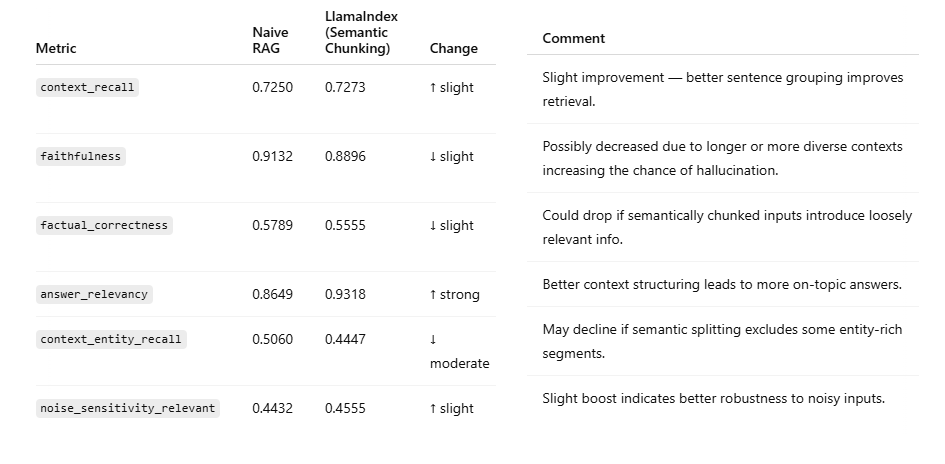

In [62]:
#cp "/mnt/c/Users/spdhn/OneDrive/Desktop/AIM06/SemanticChunking_naive_comparison.png" .
from IPython.display import Image, display

# Display the image directly
display(Image('SemanticChunking_naive_comparison.png'))